# Thesis code
- Emil Javůrek, 13331124

In [1]:
from epidemic_function import * #my file
from simulation import * #my file
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import defaultdict
from itertools import product
from itertools import zip_longest
import seaborn as sns
import pandas as pd
from matplotlib.font_manager import FontProperties
import ipywidgets as widgets
from IPython.display import display, clear_output


## Intro figure

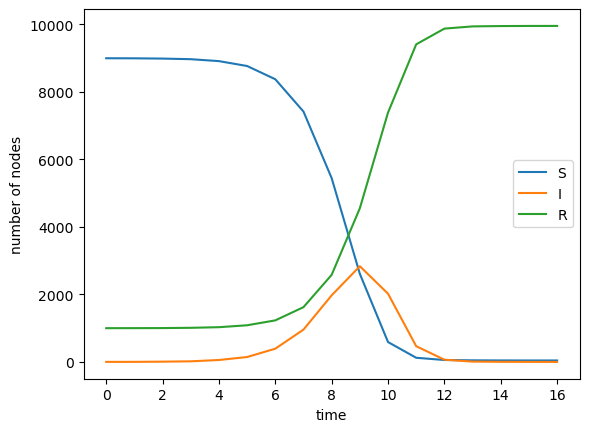

In [2]:
G = nx.connected_watts_strogatz_graph(10**4, 4, 0.5)
beta = 0.95
gamma = 1
t,S,I,R = SIR(G, beta, gamma, rho = 0.1)
plt.plot(t,S, label = "S")
plt.plot(t,I, label = "I")
plt.plot(t,R, label = "R")
plt.legend()
plt.xlabel("time")
plt.ylabel("number of nodes")
plt.show()

## Preprocessing/Setup

In [3]:
#load data
filepath = f"Data_final/Data_batches_range(4, 8).pickle"
with open(filepath, 'rb') as f:
    data = pickle.load(f)

In [4]:
#ranges
p_array = 10**np.arange(-2,0.1,0.1)
batch_array = range(32)
batches = batch_array[4:8] #to save runtime
beta = 0.45
gamma = 1
rho_array = np.arange(0,1,0.1)
chi = 0.004
strat_array = [arbitrary, highest_degree, highest_CC, lowest_CC]
strat_label = ["random", "highest degree", "highest CC", "lowest CC"]
mutation_array = [True,False]
mutation_label = ["with mutation", "base model"]

In [5]:
#sanity check
keys = list(data.keys())
print(keys[0]) #(p,beta,gamma,rho,chi,strat,mutation)
print(len(keys))
print(len(p_array)*len(rho_array)*len(strat_array)*len(mutation_array)) 

(0.01, 0.45, 1, 0.0, 0.004, 'arbitrary', True)
1680
1680


In [6]:
def average_r(data):
    """
    Gets the average r over all simulations of each parameter configuration
    Result stored in a library
    """
    N = 10**4
    r_dict = {} #output
    for par_configs, simuls in data.items(): #iterate parameter configurations
        r_avg = 0
        rho = par_configs[3]
        for simul in simuls: #iterate individual simulations
            if rho == 1:
                r = 1
            else:
                N_r = simul[3][-1]
                r = (N_r-rho*N)/((1-rho)*N) #final R minus vaccinated divided by starting susceptible
            r_avg += r
        r_dict[par_configs] = r_avg/len(simuls)
    return r_dict    

In [7]:
r_dict = average_r(data)

In [8]:
#sanity check
print(len(list(r_dict.keys())))
print(r_dict[keys[0]])

1680
0.0021600585937499956


##  $\rho$ - r relationship

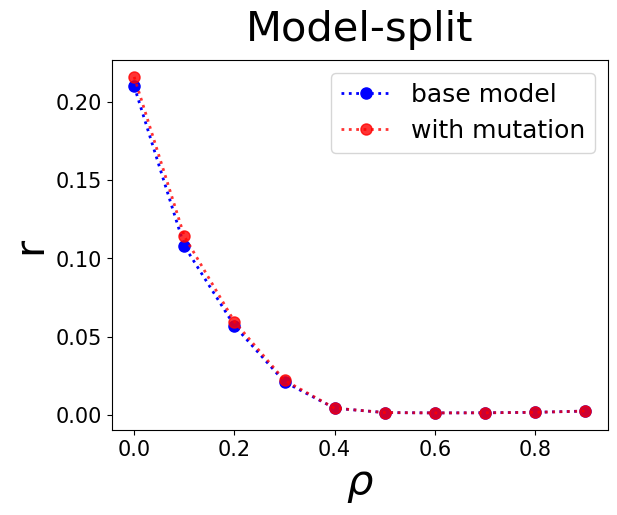

In [9]:
#mutation partition
y_data_False = []
for rho in rho_array:
    y = 0
    for p,strat in product(p_array,strat_array): 
        key = (p,beta,gamma,rho,chi,strat.__name__,False) 
        y += r_dict[key]
    l = len(p_array)*len(strat_array) 
    y_data_False.append(y/l)

y_data_True = []
for rho in rho_array:
    y = 0
    for p,strat in product(p_array,strat_array): 
        key = (p,beta,gamma,rho,chi,strat.__name__,True) 
        y += r_dict[key]
    l = len(p_array)*len(strat_array) 
    y_data_True.append(y/l)

plt.plot(rho_array,y_data_False, label = "base model", linewidth=2, linestyle = ":", marker = 'o', markersize = 8, color = "blue", alpha = 1)
plt.plot(rho_array,y_data_True, label = "with mutation", linewidth=2, linestyle = ":", marker = 'o', markersize = 8, color = "red", alpha = 0.8)
plt.legend(fontsize = 18)
plt.title("Model-split", fontsize = 30, y = 1.03)
plt.xlabel(r'$\rho$', fontsize = 30)
plt.ylabel("r", fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('Plots/June9_fig2_mutpart.png', dpi= 500, bbox_inches='tight', pad_inches=0.5)
plt.show()

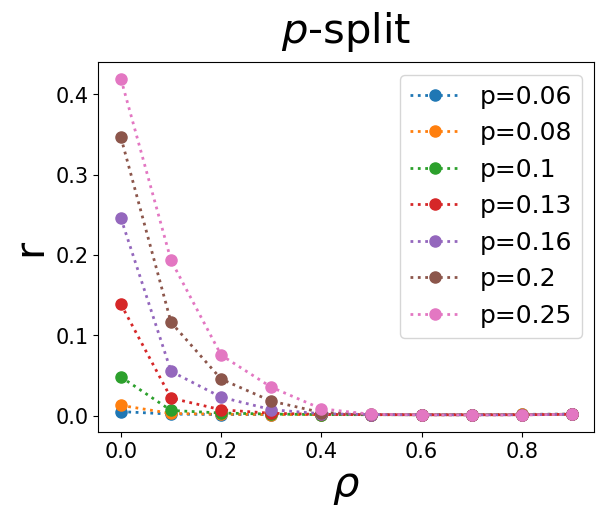

In [10]:
#per p
for p in p_array[8:15]: 
    y_data = []
    for rho in rho_array:
        avg = 0
        for strat,mutation in product(strat_array,mutation_array):
            key = (p,beta,gamma,rho,chi,strat.__name__,mutation)
            avg += r_dict[key]
        y_data.append(avg/(len(strat_array)*len(mutation_array)))
    plt.plot(rho_array,y_data,label = f"p={round(p,2)}",linestyle = ":", linewidth = 2, marker = "o", markersize = 8)

plt.xlabel(r'$\rho$', fontsize = 30)
plt.ylabel("r", fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 18)
plt.title(r"$p$" + "-split", fontsize = 30, y = 1.03)
plt.savefig('Plots/June9_fig2_ppart_reduced.png', dpi= 500, bbox_inches='tight', pad_inches=0.5)
plt.show()

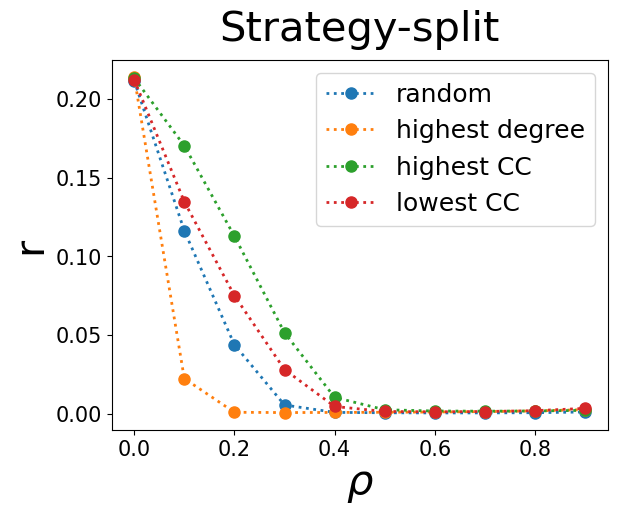

In [11]:
#per strat
for i, strat in enumerate(strat_array): 
    y_data = []
    for rho in rho_array:
        avg = 0
        for p,mutation in product(p_array,mutation_array):
            key = (p,beta,gamma,rho,chi,strat.__name__,mutation)
            avg += r_dict[key]
        y_data.append(avg/(len(p_array)*len(mutation_array)))
    plt.plot(rho_array,y_data,label = f"{strat_label[i]}", linewidth = 2, linestyle = ":", marker = "o", markersize = 8) #dont plot the labels, too many!

plt.xlabel(r'$\rho$', fontsize = 30)
plt.ylabel("r", fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Strategy-split", fontsize = 30, y = 1.03)
plt.legend(fontsize = 18)
plt.savefig('Plots/June9_fig2_astratpart.png', dpi= 500, bbox_inches='tight', pad_inches=0.5)
plt.show()

## p-r relationship

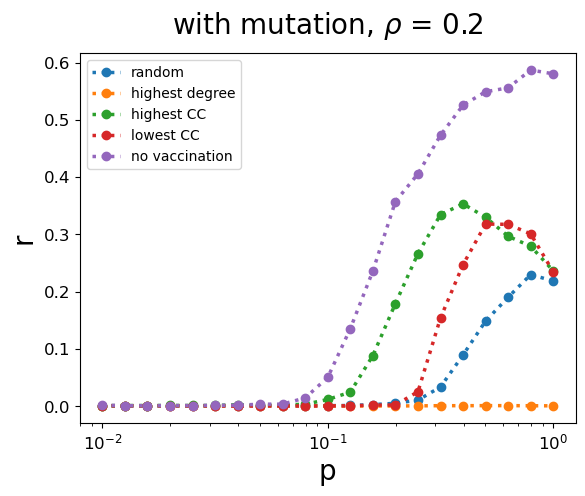

In [12]:
#mutation true

rho = 0.2
#strats
for i, strat in enumerate(strat_array):
    y_data = []
    for p in p_array:
        key = (p,beta,gamma,rho,chi,strat.__name__,True) #last is mutation, now only True
        y_data.append(r_dict[key])
    plt.plot(p_array,y_data, label = f"{strat_label[i]}", linewidth = 2.5, linestyle = ":", marker = "o", markersize = 6)

#no vaccination
y_data = []
for p in p_array:
    key = (p,beta,gamma,0,chi,"arbitrary",True)
    y_data.append(r_dict[key])
plt.plot(p_array,y_data, label = "no vaccination", linewidth = 2.5, linestyle = ":", marker = "o", markersize = 6)
    
    

plt.legend()
plt.title("with mutation, " + r"$\rho$ = 0.2", fontsize = 20, y = 1.03)
plt.xscale("log")
plt.xlabel("p", fontsize = 20)
plt.ylabel("r", fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Plots/June9_fig3_mutTrue.png', dpi= 500, bbox_inches='tight', pad_inches=0.5)
plt.show()

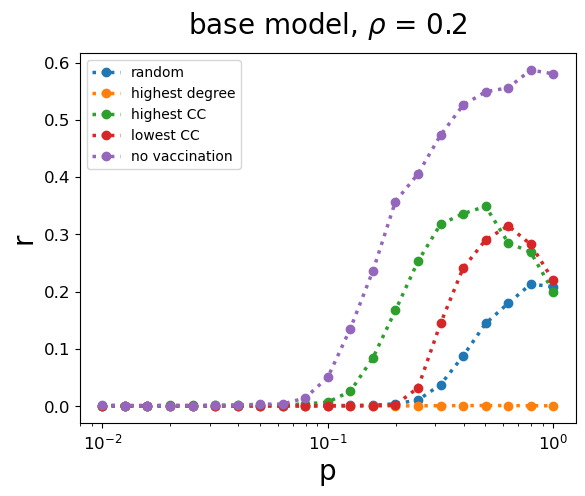

In [13]:
#mutation false

rho = 0.2
#strats
for i, strat in enumerate(strat_array):
    y_data = []
    for p in p_array:
        key = (p,beta,gamma,rho,chi,strat.__name__,False) #last is mutation, now only False
        y_data.append(r_dict[key])
    plt.plot(p_array,y_data, label = f"{strat_label[i]}", linewidth = 2.5, linestyle = ":", marker = "o", markersize = 6)

#no vaccination
y_data = []
for p in p_array:
    key = (p,beta,gamma,0,chi,"arbitrary",True)
    y_data.append(r_dict[key])
plt.plot(p_array,y_data, label = "no vaccination", linewidth = 2.5, linestyle = ":", marker = "o", markersize = 6)
    
    

plt.legend()
plt.title("base model, " + r"$\rho$ = 0.2", fontsize = 20, y = 1.03)
plt.xscale("log")
plt.xlabel("p", fontsize = 20)
plt.ylabel("r", fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Plots/June9_fig3_mutFalse.png', dpi= 500, bbox_inches='tight', pad_inches=0.5)
plt.show()

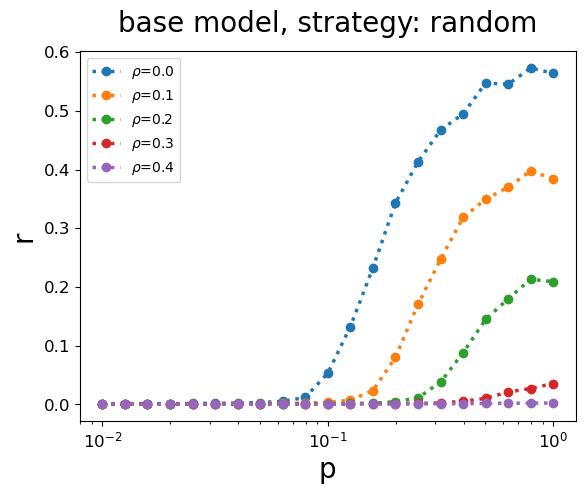

In [14]:
#arbitrary, all rho individual line, False

for rho in rho_array[:5]:
    y_data = []
    for p in p_array:
        key = (p,beta,gamma,rho,chi,"arbitrary",False)
        y_data.append(r_dict[key])
    plt.plot(p_array, y_data, label = r'$\rho$' + f"={round(rho,1)}", linewidth = 2.5, linestyle = ":", marker = "o", markersize = 6)
    
plt.title("base model, strategy: random", fontsize = 20, y = 1.03)
plt.xlabel("p", fontsize = 20)
plt.ylabel("r", fontsize = 20)
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('Plots/June9_fig3_rhopart_mutFalse.png', dpi= 500, bbox_inches='tight', pad_inches=0.5)
plt.show()



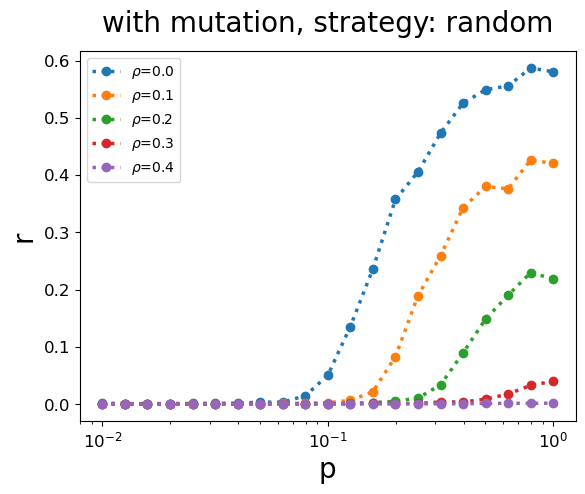

In [15]:
#arbitrary, all rho individual line, False

for rho in rho_array[:5]:
    y_data = []
    for p in p_array:
        key = (p,beta,gamma,rho,chi,"arbitrary",True)
        y_data.append(r_dict[key])
    plt.plot(p_array, y_data, label = r'$\rho$' + f"={round(rho,1)}", linewidth = 2.5, linestyle = ":", marker = "o", markersize = 6)
    
plt.title("with mutation, strategy: random", fontsize = 20, y = 1.03)
plt.xlabel("p", fontsize = 20)
plt.ylabel("r", fontsize = 20)
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('Plots/June9_fig3_rhopart_mutTrue.png', dpi= 500, bbox_inches='tight', pad_inches=0.5)
plt.show()

## Heatmaps

In [16]:
def heatmap_data(strat_name, mutation,r_dicty):
    #convert the dictionary to fit my previous code
    my_dicty = {} 
    for par_config,r_avg in r_dicty.items():
        if par_config[5] == strat_name and par_config[6] == mutation: #should also include condition on mutation
            my_dicty[par_config[3],par_config[0]] =  r_avg
    return my_dicty

In [17]:
def plot_heatmap(data, strat_name, mutation, i, j):
    multi_index = pd.MultiIndex.from_tuples(list(data.keys()), names=['rho', 'p'])
    values = pd.Series(list(data.values()), index=multi_index)
    df = values.unstack(level=0).sort_index(ascending=False)
    
    title_font = FontProperties()
    title_font.set_style('italic')

    sns.heatmap(df, cmap='viridis', ax=axs[i, j])
    axs[i, j].set_title(f"{strat_label[j]}, {mutation_label[i]}", fontsize = 40, y = 1.05, fontproperties=title_font)
    axs[i, j].set_xlabel(r'$\rho$', fontsize = 50)
    axs[i, j].set_ylabel('p', fontsize = 50, labelpad=20)
    axs[i, j].tick_params(left=False, bottom=False)

    xtick_labels = [f'{x:.2f}' for x in df.columns]
    ytick_labels = [f'{y:.2f}' for y in df.index]

    axs[i, j].set_xticks(np.arange(len(df.columns)) + 0.5)
    axs[i, j].set_xticklabels(xtick_labels, rotation=45, ha='right')

    axs[i, j].set_yticks(np.arange(len(df.index)) + 0.5)
    axs[i, j].set_yticklabels(ytick_labels, rotation=0)

    axs[i, j].xaxis.set_tick_params(labelsize=25)
    axs[i, j].yaxis.set_tick_params(labelsize=25)
    
    # Show only every third y tick
    for idx, label in enumerate(axs[i, j].get_yticklabels()):
        if idx % 2 != 0:
            label.set_visible(False)
            
    # Adjust the fontsize of y-axis tick labels on the strip
    axs[i, j].collections[0].colorbar.ax.yaxis.set_tick_params(labelsize=25)

<Figure size 200x1000 with 0 Axes>

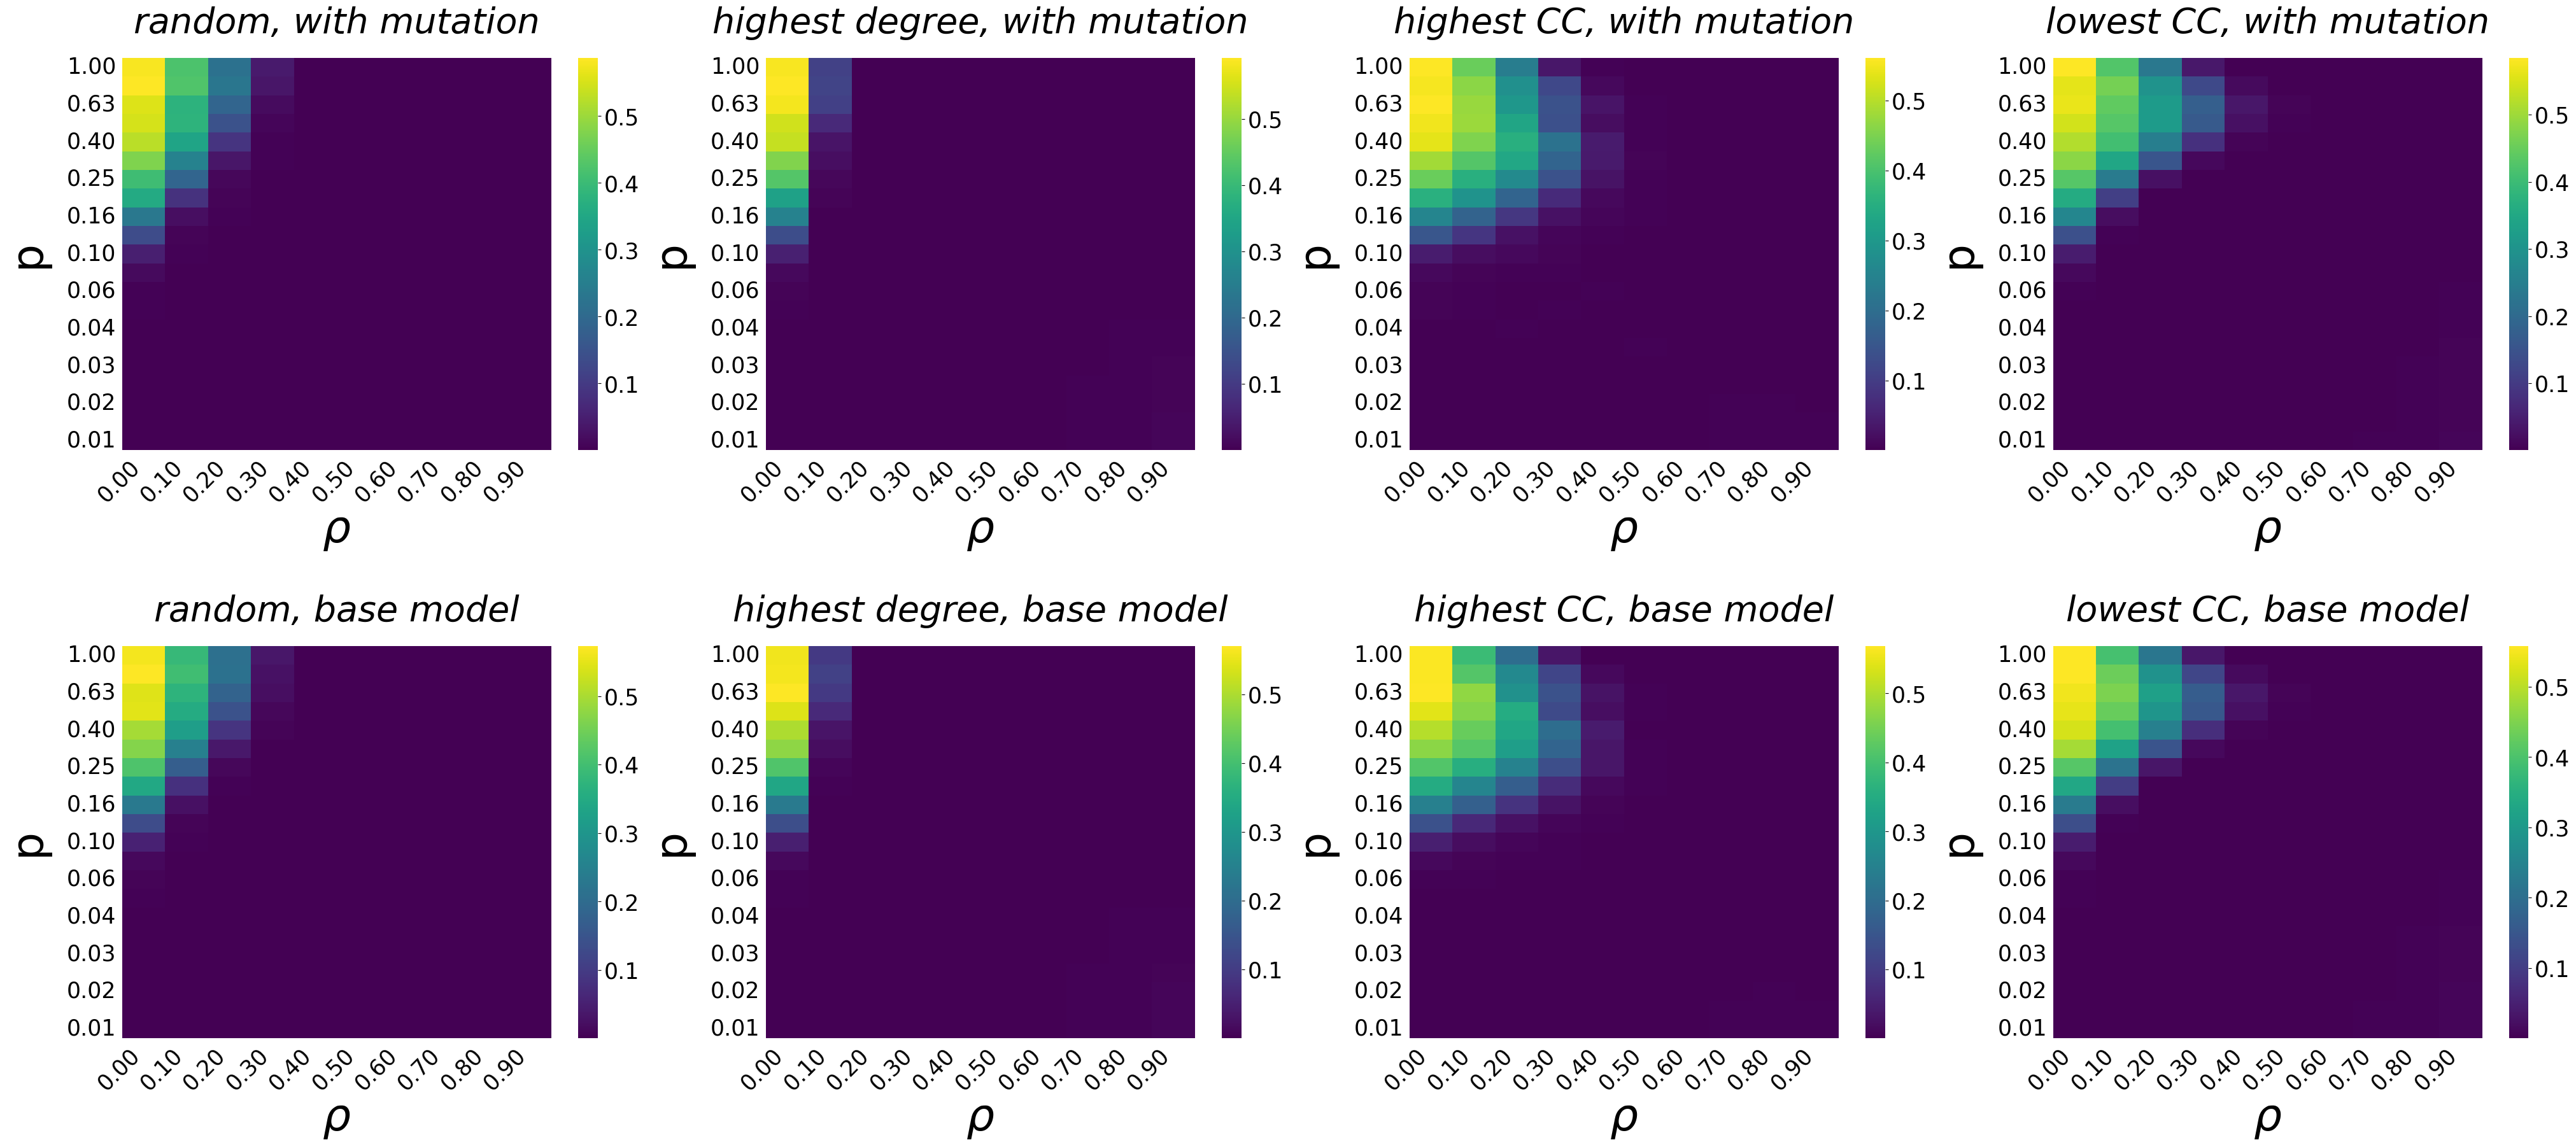

In [18]:
fig_width = 2
fig_height = 10
plt.figure(figsize=(fig_width, fig_height))
plt.tight_layout()
fig, axs = plt.subplots(ncols=len(strat_array), nrows=len(mutation_array), figsize=(50, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.20)


for i, strat in enumerate(strat_array):
    for j, mutation in enumerate(mutation_array):
        dataa = heatmap_data(strat.__name__, mutation, r_dict)
        plot_heatmap(dataa, strat.__name__, mutation, j, i)

plt.savefig('Plots/June9_heatmap_reverse.png', dpi= 500, bbox_inches='tight')
plt.show()

### Heatmaps for extreme $\chi = 0.01$

In [19]:
#load data
filepath2 = f"Data_final/Data_batches_range(4, 8)_extreme_chi.pickle"
with open(filepath, 'rb') as f:
    data2 = pickle.load(f)

In [20]:
chi = 0.01
r_dict_extreme = average_r(data2)

<Figure size 200x1000 with 0 Axes>

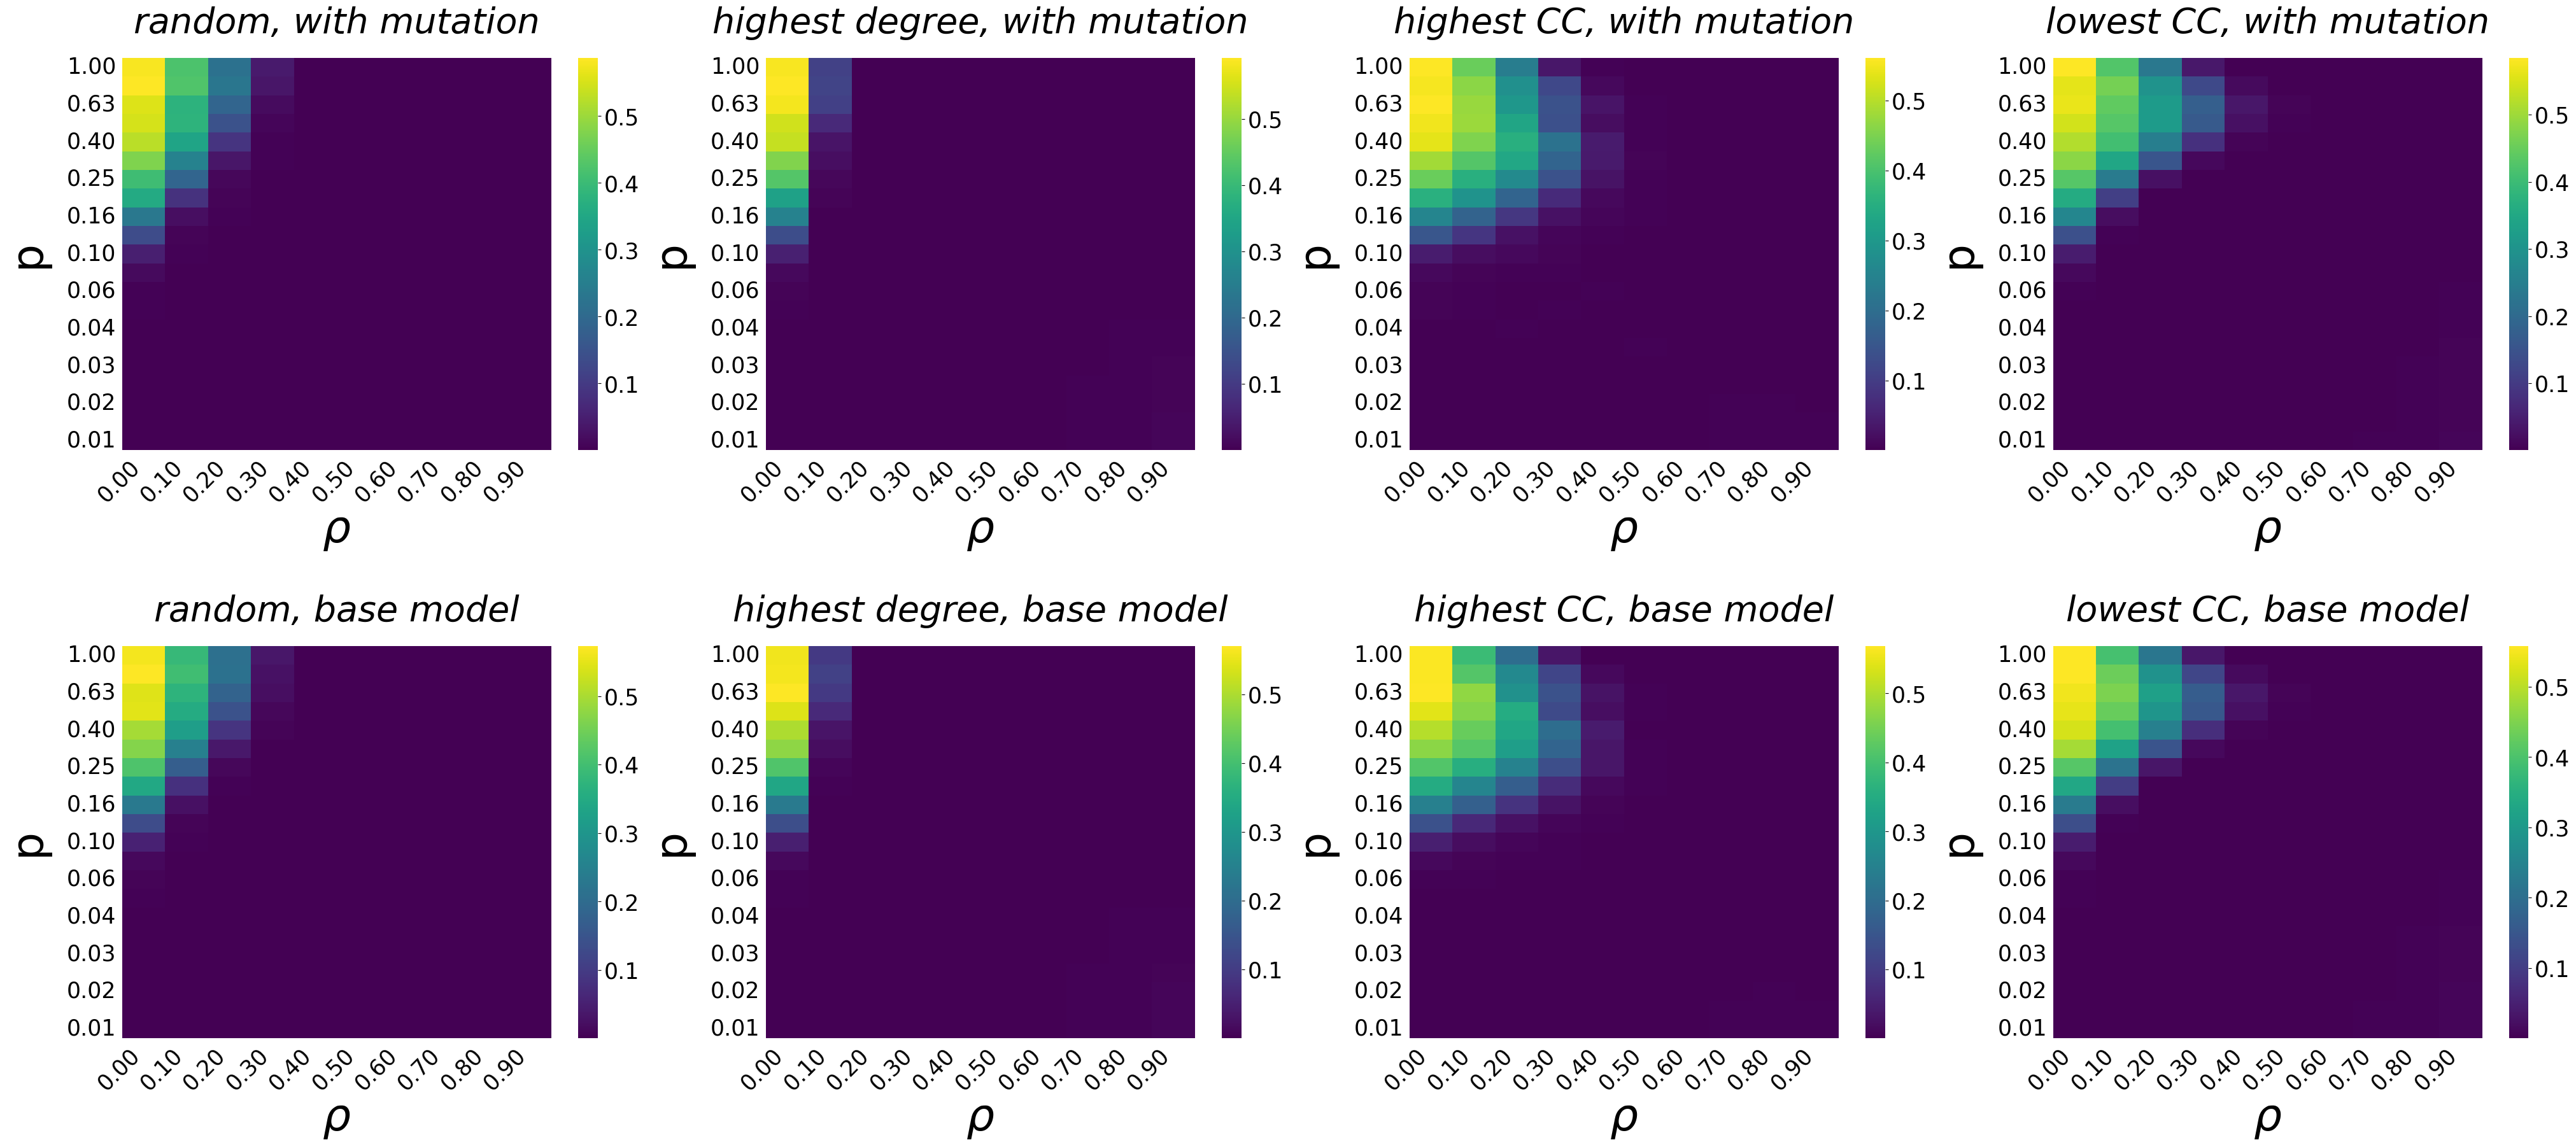

In [21]:
fig_width = 2
fig_height = 10
plt.figure(figsize=(fig_width, fig_height))
plt.tight_layout()
fig, axs = plt.subplots(ncols=len(strat_array), nrows=len(mutation_array), figsize=(50, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.20)


for i, strat in enumerate(strat_array):
    for j, mutation in enumerate(mutation_array):
        dataaa = heatmap_data(strat.__name__, mutation, r_dict_extreme)
        plot_heatmap(dataaa, strat.__name__, mutation, j, i)

plt.savefig('Plots/June9_heatmap_extreme_chi.png', dpi= 500, bbox_inches='tight')
plt.show()